In [7]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import logging

from scipy import stats, signal
from pathlib import Path
from src.lib.class_load import LoadFiles
from src.data.save_models import SAVE_DIR
from src.lib.utils import select_best_model
from src.lib.factory_data import SQLDataSourceFactory, get_data, create_table, set_data
from src.lib.factory_models import ModelContext
from src.lib.factory_prepare_data import (
    DataCleaner,
    DataModel,
    MeanImputation,
    OutliersToIQRMean,
    PrepareDtypeColumns,
    base_dtypes
)
from src.models.DP_model import Modelos
from src.features.features_redis import HandleRedis
from src.features.features_postgres import HandleDBpsql
from src.models.args_data_model import Parameters
from src.data.logs import LOGS_DIR

In [8]:
path_folder = os.path.dirname(
    '/home/bdebian/Documents/Projects/app_prediction/src')
folder_model = Path(path_folder).joinpath("scr/data/save_models")

handler_load = LoadFiles()
handler_redis = HandleRedis()
ruta_actual = os.path.dirname(
    '/home/bdebian/Documents/Projects/app_prediction/src')

# =================================================================
#             Configuracion Logger
# =================================================================
# Configura un logger personalizado en lugar de usar el logger raíz
logfile = ruta_actual + "/src/data/config/logging.conf"
logging.config.fileConfig(os.path.join(LOGS_DIR, logfile))
logger = logging.getLogger("train")
logger.debug("Inciando secuencia de entrenamiento")

# =================================================================
#             Cargar los parametros
# =================================================================
CONFIG_FILE = ruta_actual + "/src/data/config/config.yaml"
with open(CONFIG_FILE, "r", encoding="utf-8") as file:
    parameters = yaml.safe_load(file)

logger.debug("Archivo de configuraciones cargado")
parametros = Parameters(**parameters)
# =================================================================
#             Cargar datos de la fuente de datos
# =================================================================
# Interacion para hacer un cache de los datos en redis
try:
    logger.debug("verficando si existe data cache")
    data = handler_redis.get_cache_data(
        hash_name=parametros.query_template["table"],
        config=parametros.connection_data_source,
    )
    # Condicional para actualizar datos en caso de existan datos en redis
    if data is not None:
        logger.debug("Existe data en cache")

        # Secuencia de codigo para perdir nuevos datos a la base de datos
        date_col_query = parameters["query_template"]["columns"]["0"]
        LAST_DAY = str(data.iloc[-1][0])
        parameters["query_template"]["where"] = f" \"{date_col_query}\" > '{LAST_DAY}'"
        parameters["query_template"]["order"] = "".join(
            ['"' + columna + '"' for columna in [date_col_query]])

        logger.debug("Realizando peticion a la fuente de datos")

        # Extraccion de la nueva data para actualizar
        new = get_data(SQLDataSourceFactory(**parameters))
        logger.debug("Actualizando cache en redis")
        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template["table"],
            old_dataframe=data,
            new_dataframe=new,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source,
        )
        logger.debug("Actualizacion completa de datos en redis")

    # Verificar que existieran datos en cache
    if data is None:
        logger.debug("No existe cache de datos")

        data = get_data(SQLDataSourceFactory(**parameters))
        logger.debug("Insertando datos de cache en redis")
        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template["table"],
            old_dataframe=data,
            new_dataframe=None,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source,
        )

except ValueError as error:
    logger.debug("[ERROR] No se puede hacer un cache de la fuente de datos")
    logger.debug(error)
    exit()

2024-04-08 17:17:27,027 - train - DEBUG - Inciando secuencia de entrenamiento
2024-04-08 17:17:27,027 - train - DEBUG - Inciando secuencia de entrenamiento
2024-04-08 17:17:27,032 - train - DEBUG - Archivo de configuraciones cargado
2024-04-08 17:17:27,032 - train - DEBUG - Archivo de configuraciones cargado
2024-04-08 17:17:27,033 - train - DEBUG - verficando si existe data cache
2024-04-08 17:17:27,033 - train - DEBUG - verficando si existe data cache
2024-04-08 17:17:27,150 - train - DEBUG - Existe data en cache
2024-04-08 17:17:27,150 - train - DEBUG - Existe data en cache
2024-04-08 17:17:27,151 - train - DEBUG - Realizando peticion a la fuente de datos
2024-04-08 17:17:27,151 - train - DEBUG - Realizando peticion a la fuente de datos
2024-04-08 17:17:27,173 - train - DEBUG - Actualizando cache en redis
2024-04-08 17:17:27,173 - train - DEBUG - Actualizando cache en redis
2024-04-08 17:17:27,208 - datasource - DEBUG - Recuperando data existente
2024-04-08 17:17:27,208 - datasource

In [11]:
# =================================================================
#             Limpieza de datos
# =================================================================
# Nuevos datos para reemplazar en las columnas
new_types = []

for dtypo in parameters["type_data"].values():
    new_types.append(base_dtypes[dtypo])

# metodo para transformar los tipo de datos
strategy = {int: np.mean, float: np.mean, object: stats.mode}

# Estrategias para imputar los datos faltantes de NA
replace = {
    int: lambda x: int(float(x.replace(",", ""))),
    float: lambda x: float(x.replace(",", "")),
    object: lambda x: x.strip(),
}
# =================================================================

update_dtype_columns = PrepareDtypeColumns(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters,
)

# Ejecucion de fabrica para aplicar y ordenar los tipos de datos y los valores
cleaner = DataCleaner()
cleaner.strategy = update_dtype_columns
data_ = cleaner.clean(data)

# Condicion de filtrado para informacion segun los valores
filter_label: str = parameters["filter_data"]["filter_1_feature"]
if not isinstance(filter_label, str):
    filter_label = str(filter_label)
filter_col: str = parameters["filter_data"]["filter_1_column"]
filter_product = data_.dataframe[filter_col] == filter_label
filter_data = data_.dataframe[filter_product].sort_values(
    by=parameters["filter_data"]["date_column"])

# Seleccion de agrupacion de tiempo
parameters["filter_data"]["group_frequecy"] = "M"
# parameters["filter_data"]["filter_1_feature"] = filter_label

# # Datos de validacion
# validate_data = filter_data.set_index(time_series_col)["2023-12-01":].reset_index()

# # Datos de entrenamiento
# filter_data = filter_data.set_index(parameters["filter_data"]["date_column"])[
#     :"2023-11-30"].reset_index()

outliners = OutliersToIQRMean(**parameters)
cleaner.strategy = outliners
outlines_data = cleaner.clean(filter_data)
# validate_outlines = cleaner.clean(validate_data)

# Filtrado de datos para eliminar valores negativos
filter_values = outlines_data["quantity"] <= 0
outlines_data[filter_values] = 0.1
# =================================================================
#             Filtro pasabajos
# =================================================================
fs = 1 / 24 / 3600  # 1 day in Hz (sampling frequency)

nyquist = fs / 0.5  # 2 # 0.5 times the sampling frequency
cutoff = 0.5 # 0.1 fraction of nyquist frequency, here  it
# print("cutoff= ", 1 / cutoff * nyquist * 24 * 3600, " days")
# cutoff=  4.999999999999999  days
b, a = signal.butter(5, cutoff, btype="lowpass")  # low pass filter

dUfilt = signal.filtfilt(b, a, outlines_data["quantity"])
dUfilt = np.array(dUfilt)
dUfilt = dUfilt.transpose()
outlines_data["low_past"] = dUfilt

# =================================================================
#             Preparacion de datos para el modelo
# =================================================================
data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model
data_ready, scaler_data = cleaner.clean(outlines_data)

# Creacion del dataframe para del filtro pasa bajo para los datos
low_pass_data = outlines_data["low_past"]
low_pass_data = low_pass_data.to_frame()
low_pass_data.rename(columns={"low_past": "quantity"}, inplace=True)
data_ready_lp, scaler_data_lp = cleaner.clean(low_pass_data)

/home/bdebian/Documents/Projects/app_prediction/src/features/features_fix_data.py:272: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.dataframe = self.dataframe.groupby([pd.Grouper(freq=frequency_group)])[col_group].sum()


In [8]:
metric_eval: dict = {}

modelos_list_used = [
    # "BlockRNNModel",
    "NBeatsModel",
    # "TCNModel",
    "TransformerModel",
    # "TFTModel",
    # "DLinealModel",
    # "NLinearModel",
]

for selected_model in modelos_list_used:
    MODE_USED = selected_model
    print(f"Entrenando {selected_model}")

    modelo = ModelContext(
        model_name=MODE_USED,
        data=data_ready,
        split=70,
        covarianze=data_ready_lp,
        **parameters
    )

    # Entrenar el modelo
    model_trained = modelo.train()

    # Optimizar los parametros del modelo
    if parameters["optimize"]:
        print("Optimizando parametros del modelo")
        model_trained = modelo.optimize()

    # Guargar los modelos entrenados
    modelo.save(model_trained, scaler=scaler_data, scaler_name="scaler")
    modelo.save(None, scaler=scaler_data_lp, scaler_name="scaler_lp")

    print("metodo finalizado")

Entrenando NBeatsModel
Modelo importado NBeatsModel


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

No parameter File, [Errno 2] No such file or directory: '/home/bdebian/Documents/Projects/app_prediction/src/data/save_models/24307A/train_metrics.json'
Optimizando parametros del modelo


/home/bdebian/Documents/Projects/app_prediction/src/models/DP_model.py:364: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler=optuna.samplers.QMCSampler(), direction="minimize"  # PartialFixedSampler


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.061564
2023-09-24  0.037511


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :21.173408491921514
smapes: 24.47742094516944
Current value: 24.47742094516944, Current params: {'input_chunk_length': 5, 'output_chunk_length': 2, 'lr': 0.0003881456373498174, 'num_blocks': 6, 'num_stacks': 4, 'layer_widths': 256, 'generic_architecture': True, 'dropout': 0.1805421000424846, 'batch_size': 185}
Best value: 24.47742094516944, Best params: {'input_chunk_length': 5, 'output_chunk_length': 2, 'lr': 0.0003881456373498174, 'num_blocks': 6, 'num_stacks': 4, 'layer_widths': 256, 'generic_architecture': True, 'dropout': 0.1805421000424846, 'batch_size': 185}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17   0.04497


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :20.827368377224712
smapes: 23.248381394625078
Current value: 23.248381394625078, Current params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'num_blocks': 1, 'num_stacks': 1, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.0, 'batch_size': 64}
Best value: 23.248381394625078, Best params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'num_blocks': 1, 'num_stacks': 1, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.0, 'batch_size': 64}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.034931


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :38.50259422625299
smapes: 47.68199717114213
Current value: 47.68199717114213, Current params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'num_blocks': 5, 'num_stacks': 8, 'layer_widths': 128, 'generic_architecture': True, 'dropout': 0.2, 'batch_size': 287}
Best value: 23.248381394625078, Best params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'num_blocks': 1, 'num_stacks': 1, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.0, 'batch_size': 64}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.036499


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :35.74092004160942
smapes: 43.51774045083311
Current value: 43.51774045083311, Current params: {'input_chunk_length': 6, 'output_chunk_length': 1, 'lr': 0.00010573712634405648, 'num_blocks': 3, 'num_stacks': 12, 'layer_widths': 128, 'generic_architecture': True, 'dropout': 0.30000000000000004, 'batch_size': 175}
Best value: 23.248381394625078, Best params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'num_blocks': 1, 'num_stacks': 1, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.0, 'batch_size': 64}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.078240
2023-09-24  0.075464


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :35.30295265917535
smapes: 29.98804764176846
Current value: 29.98804764176846, Current params: {'input_chunk_length': 4, 'output_chunk_length': 2, 'lr': 0.0004728708045015881, 'num_blocks': 8, 'num_stacks': 4, 'layer_widths': 512, 'generic_architecture': False, 'dropout': 0.1, 'batch_size': 399}
Best value: 23.248381394625078, Best params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'num_blocks': 1, 'num_stacks': 1, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.0, 'batch_size': 64}
Best value: 23.248381394625078, Best params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'num_blocks': 1, 'num_stacks': 1, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.0, 'batch_size': 64}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

metodo finalizado
Entrenando TCNModel
Modelo importado TCNModel


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Optimizando parametros del modelo


/home/bdebian/Documents/Projects/app_prediction/src/models/DP_model.py:364: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler=optuna.samplers.QMCSampler(), direction="minimize"  # PartialFixedSampler
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.093013
2023-09-24  0.114031


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :82.25721788771607
smapes: 57.67379003349751
Current value: 57.67379003349751, Current params: {'input_chunk_length': 6, 'output_chunk_length': 2, 'lr': 0.000285850213568469, 'dilation_base': 3, 'weight_norm': True, 'kernel_size': 5, 'num_filters': 6}
Best value: 57.67379003349751, Best params: {'input_chunk_length': 6, 'output_chunk_length': 2, 'lr': 0.000285850213568469, 'dilation_base': 3, 'weight_norm': True, 'kernel_size': 5, 'num_filters': 6}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17   -0.0548


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :196.47819544728367
smapes: 200.0
Current value: 200.0, Current params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'dilation_base': 2, 'weight_norm': False, 'kernel_size': 3, 'num_filters': 6}
Best value: 57.67379003349751, Best params: {'input_chunk_length': 6, 'output_chunk_length': 2, 'lr': 0.000285850213568469, 'dilation_base': 3, 'weight_norm': True, 'kernel_size': 5, 'num_filters': 6}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.043668


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :23.119276748820987
smapes: 26.141092510109786
Current value: 26.141092510109786, Current params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'dilation_base': 3, 'weight_norm': False, 'kernel_size': 4, 'num_filters': 9}
Best value: 26.141092510109786, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'dilation_base': 3, 'weight_norm': False, 'kernel_size': 4, 'num_filters': 9}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.224673


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :295.5517867118918
smapes: 119.28189732619097
Current value: 119.28189732619097, Current params: {'input_chunk_length': 6, 'output_chunk_length': 1, 'lr': 0.00010573712634405648, 'dilation_base': 2, 'weight_norm': False, 'kernel_size': 5, 'num_filters': 11}
Best value: 26.141092510109786, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'dilation_base': 3, 'weight_norm': False, 'kernel_size': 4, 'num_filters': 9}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.141620
2023-09-24  0.152621


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :159.0148749051818
smapes: 88.50287181768944
Current value: 88.50287181768944, Current params: {'input_chunk_length': 4, 'output_chunk_length': 2, 'lr': 0.0004728708045015881, 'dilation_base': 4, 'weight_norm': False, 'kernel_size': 3, 'num_filters': 7}
Best value: 26.141092510109786, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'dilation_base': 3, 'weight_norm': False, 'kernel_size': 4, 'num_filters': 9}
Best value: 26.141092510109786, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'dilation_base': 3, 'weight_norm': False, 'kernel_size': 4, 'num_filters': 9}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

metodo finalizado
Entrenando TransformerModel
Modelo importado TransformerModel


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Optimizando parametros del modelo


/home/bdebian/Documents/Projects/app_prediction/src/models/DP_model.py:364: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler=optuna.samplers.QMCSampler(), direction="minimize"  # PartialFixedSampler
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.070294


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :23.757140292082646
smapes: 21.234755021512278
Current value: 21.234755021512278, Current params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.0003022717254583887, 'batch_size': 174, 'num_encoder_layers': 9, 'dim_feedforward': 217}
Best value: 21.234755021512278, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.0003022717254583887, 'batch_size': 174, 'num_encoder_layers': 9, 'dim_feedforward': 217}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.219517


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :286.4731786921466
smapes: 117.77552853471273
Current value: 117.77552853471273, Current params: {'input_chunk_length': 4, 'output_chunk_length': 1, 'lr': 5.000000000000004e-05, 'batch_size': 64, 'num_encoder_layers': 1, 'dim_feedforward': 1}
Best value: 21.234755021512278, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.0003022717254583887, 'batch_size': 174, 'num_encoder_layers': 9, 'dim_feedforward': 217}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.059842


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :5.355996206534379
smapes: 5.216303692586263
Current value: 5.216303692586263, Current params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'batch_size': 287, 'num_encoder_layers': 7, 'dim_feedforward': 129}
Best value: 5.216303692586263, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'batch_size': 287, 'num_encoder_layers': 7, 'dim_feedforward': 129}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.166802


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :193.66550877306304
smapes: 98.39089504013708
Current value: 98.39089504013708, Current params: {'input_chunk_length': 6, 'output_chunk_length': 1, 'lr': 0.00010573712634405648, 'batch_size': 175, 'num_encoder_layers': 9, 'dim_feedforward': 193}
Best value: 5.216303692586263, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'batch_size': 287, 'num_encoder_layers': 7, 'dim_feedforward': 129}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

  0%|          | 0/1 [00:00<?, ?it/s]

component   quantity
created_at          
2023-09-17  0.056800
2023-09-24  0.056800
2023-10-01  0.056800
2023-10-08  0.273496
2023-10-15  0.906146
2023-10-22  0.945196
2023-10-29  1.000000
2023-11-05  0.395828
2023-11-12  0.310628
2023-11-19  0.839583
2023-11-26  0.614156
2023-12-03  0.273352
2023-12-10  0.220102
2023-12-17  0.547592
2023-12-24  0.247836
2023-12-31  0.186376
2024-01-07  0.756823
2024-01-14  0.545595
2024-01-21  0.248502
2024-01-28  0.715332
2024-02-04  0.214111
2024-02-11  0.247836
2024-02-18  0.101175
2024-02-25  0.118926
2024-03-03  0.000000
2024-03-10  0.206123
component   quantity
created_at          
2023-09-17  0.068690
2023-09-24  0.080787


  0%|          | 0/1 [00:00<?, ?it/s]

r2_score: -inf
mape :31.582415311553724
smapes: 26.909315247062516
Current value: 26.909315247062516, Current params: {'input_chunk_length': 4, 'output_chunk_length': 2, 'lr': 0.0004728708045015881, 'batch_size': 399, 'num_encoder_layers': 3, 'dim_feedforward': 65}
Best value: 5.216303692586263, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'batch_size': 287, 'num_encoder_layers': 7, 'dim_feedforward': 129}
Best value: 5.216303692586263, Best params: {'input_chunk_length': 5, 'output_chunk_length': 1, 'lr': 0.00022360679774997909, 'batch_size': 287, 'num_encoder_layers': 7, 'dim_feedforward': 129}


/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_errors / ss_tot
/home/bdebian/.virtualenvs/app_inventory/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

metodo finalizado


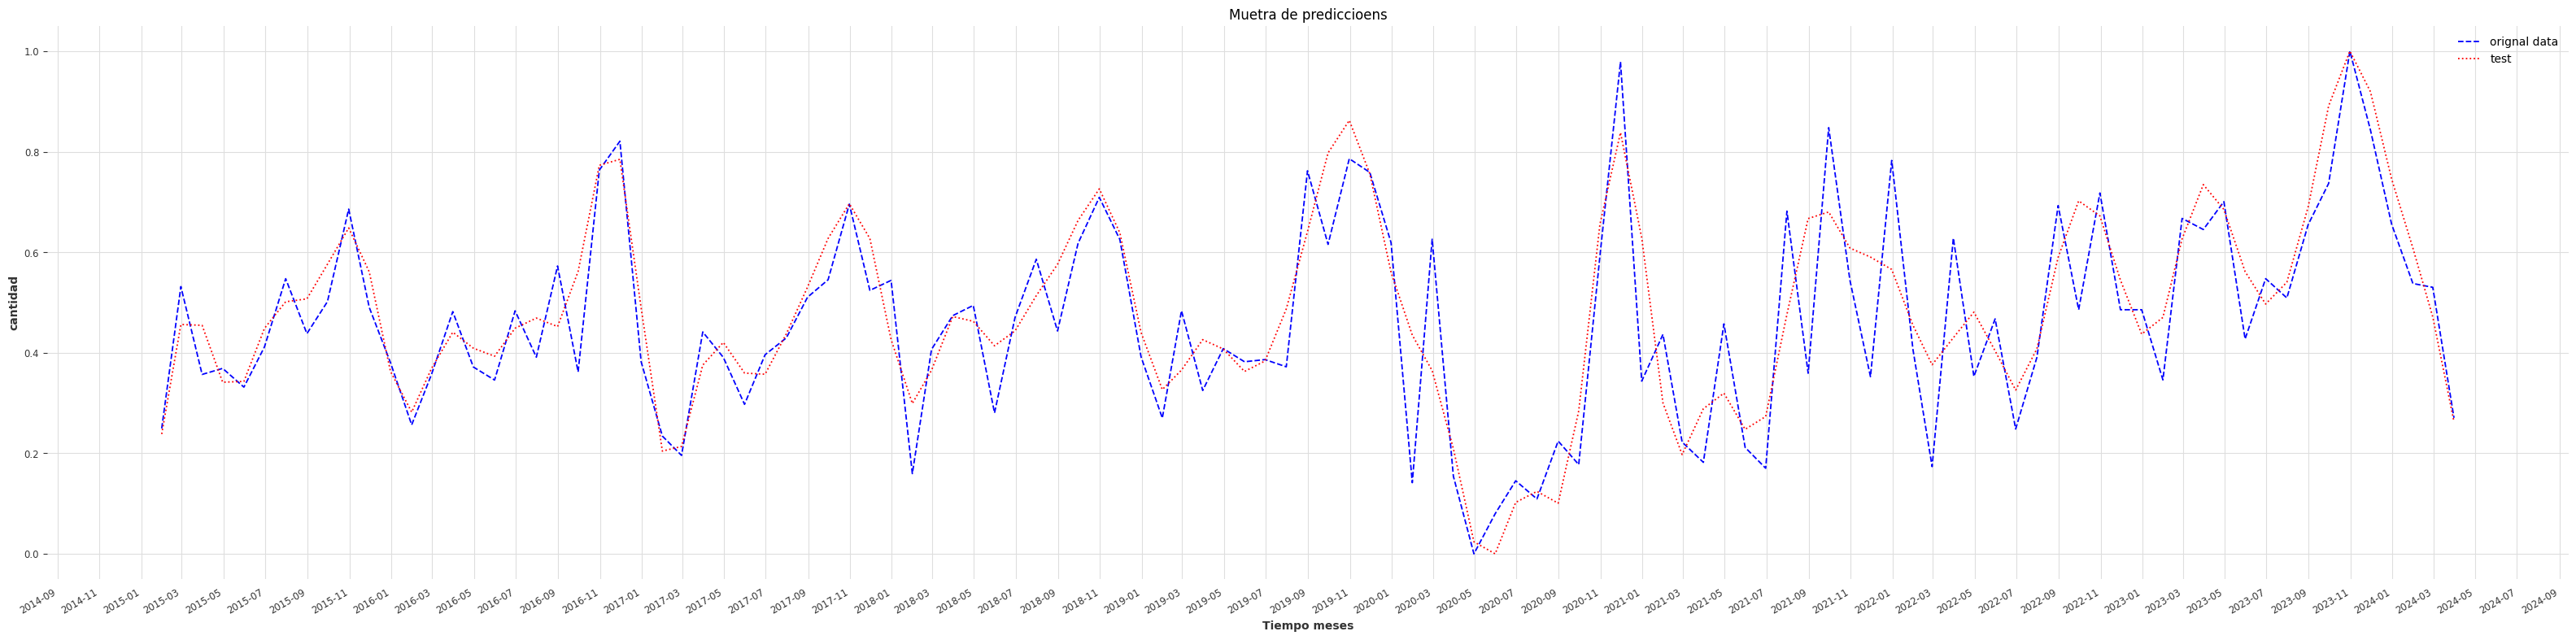

In [12]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(40, 10))


# plt.stem(outlines_data.set_index("created_at").index,
#           outlines_data['quantity'].values,
#           markerfmt='*',basefmt='--'
#           )

# plt.stem(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          markerfmt='*', basefmt='--'
#          )

plt.plot(data_ready.pd_dataframe().reset_index().set_index("created_at").index,
         data_ready.pd_dataframe().reset_index()['quantity'].values,
         c='b',
         linestyle='--'
         )

plt.plot(data_ready_lp.pd_dataframe().reset_index().set_index("created_at").index,
         data_ready_lp.pd_dataframe().reset_index()['quantity'].values,
         c='r',
         linestyle= 'dotted'
         )

# plt.plot(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          c='r',
#          marker='*'
#          )

# plt.plot(dataframe_pred_future.set_index("created_at").index,
#          dataframe_pred_future['quantity'].values,
#          c='g',
#          marker='o'
#          )

plt.title('Muestra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'data_lowpass'])  # , loc='upper right')

fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)
fig.autofmt_xdate()

plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test'], loc='upper right')
plt.show()

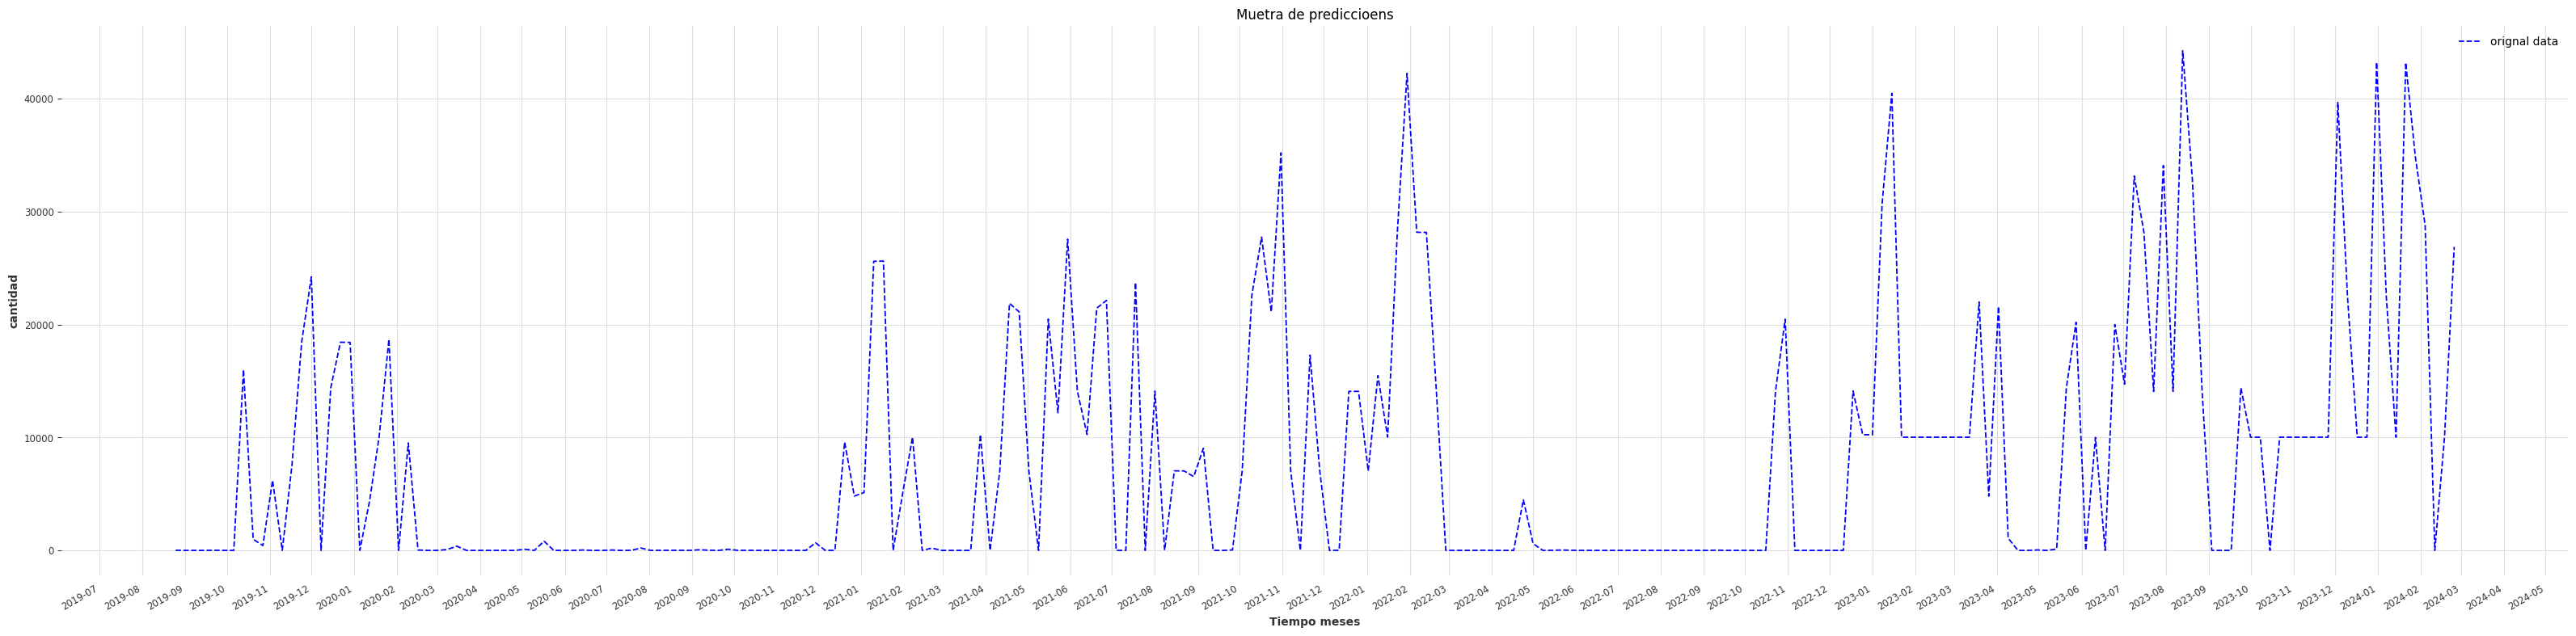

In [7]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(40, 10))

data_ready_lp.pd_dataframe()
data_ready.pd_dataframe()


# plt.stem(outlines_data.set_index("created_at").index,
#           outlines_data['quantity'].values,
#           markerfmt='*',basefmt='--'
#           )

# plt.stem(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          markerfmt='*', basefmt='--'
#          )

plt.plot(outlines_data.reset_index().set_index("created_at").index,
         outlines_data['quantity'].values,
         c='b',
         linestyle='--'
         )

# plt.plot(data_frame_predicciones.set_index("time").index,
#          data_frame_predicciones['quantity'].values,
#          c='r',
#          marker='*'
#          )

# plt.plot(dataframe_pred_future.set_index("created_at").index,
#          dataframe_pred_future['quantity'].values,
#          c='g',
#          marker='o'
#          )


plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test', 'validation'])  # , loc='upper right')

fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)
fig.autofmt_xdate()

plt.title('Muetra de prediccioens')
plt.ylabel('cantidad')
plt.xlabel('Tiempo meses')
plt.legend(['orignal data', 'test'], loc='upper right')
plt.show()

In [8]:
outlines_data

,quantity,low_past
created_at,,
2019-08-25,15.0,23.469303
2019-09-01,0.1,115.430772
2019-09-08,0.1,387.466310
2019-09-15,0.1,-161.389763
2019-09-22,15.0,-1081.856619
...,...,...
2024-01-28,34800.0,38394.882588
2024-02-04,28800.0,26515.994810
2024-02-11,0.1,6111.549043


In [7]:
data_ready.pd_dataframe()

component,quantity
created_at,
2022-07-10,0.019081
2022-07-17,0.043265
2022-07-24,0.000000
2022-07-31,0.028400
2022-08-07,0.013867
...,...
2024-02-11,0.247836
2024-02-18,0.101175
2024-02-25,0.118926
